In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import best_genetic_algorithm_class as ga
import best_team_fantasyPL_gen_alg_class as best_team

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 6]

In [10]:
# Чтение исходных данных
cleaned_players = pd.read_csv('cleaned_players.csv')
cleaned_players['first_second_name'] = cleaned_players['first_name'] + cleaned_players['second_name']
points = cleaned_players['total_points'].values
cost = cleaned_players['now_cost'].values
position = cleaned_players['element_type'].values

cleaned_players

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type,first_second_name
0,Mesut,Özil,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.6,68,MID,MesutÖzil
1,Sokratis,Papastathopoulos,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.1,48,DEF,SokratisPapastathopoulos
2,David,Luiz Moreira Marinho,0,0,9,479,9,25.8,99.4,40.0,0,70,16.5,0,0,0,0.7,54,DEF,DavidLuiz Moreira Marinho
3,Pierre-Emerick,Aubameyang,3,1,53,1346,16,214.3,198.8,433.0,4,154,84.6,5,0,2,7.2,113,MID,Pierre-EmerickAubameyang
4,Cédric,Soares,0,0,1,5,0,0.0,0.0,0.0,0,3,0.0,0,0,0,0.2,46,DEF,CédricSoares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,Taylor,Perry,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,45,MID,TaylorPerry
621,Luke,Cundle,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,45,MID,LukeCundle
622,Lewis,Richards,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,40,DEF,LewisRichards
623,Christian,Marques,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,40,DEF,ChristianMarques


In [3]:
# Инициализация параметров для расчета
BST = best_team.BestFantasyTeam(points, cost, position) # Инициализация класса

count_playes_squad = 11
max_idx = cleaned_players.shape[0]
num_iteration = 2 # Количество итераций для моделирования
cost_team = []
players = []
iteration = []
score_team = []
position_team = []

In [4]:
# Моделирование
for i in tqdm(range(num_iteration)):
        BGA = ga.BestGA(num_gen=count_playes_squad, max_value_gen=max_idx, num_epoch=200, size_population=500)
        best_person, fitness_history = BGA.optimize(BGA.initial_population, BST.fitness_glob)
        
        #plotting_learning_epoch(fitness_history, BGA.num_epoch)
        
        best_person = best_person.astype(int)
        cost_team.extend([BST.cost[best_person].sum() for k in range(count_playes_squad)])
        players.extend([player[0] for player in cleaned_players[['first_second_name']].values[best_person]])
        score_team.extend([BST.points[best_person].sum() for k in range(count_playes_squad)])
        position_team.extend([position[player] for player in best_person])
        iteration.extend([i for k in range(count_playes_squad)])
    
result_df = pd.DataFrame(np.column_stack((iteration, players, position_team, cost_team, score_team)),
                         columns=['iter', 'player', 'position', 'cost_team', 'score_team'])
result_df['iter'] = result_df['iter'].astype(int)
result_df['cost_team'] = result_df['cost_team'].astype(int)
result_df['score_team'] = result_df['score_team'].astype(int)
result_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:39<00:00, 79.68s/it]


,iter,player,position,cost_team,score_team
0,0,KurtZouma,DEF,827,1047
1,0,Heung-MinSon,MID,827,1047
2,0,NickPope,GK,827,1047
3,0,JackGrealish,MID,827,1047
4,0,PatrickBamford,FWD,827,1047


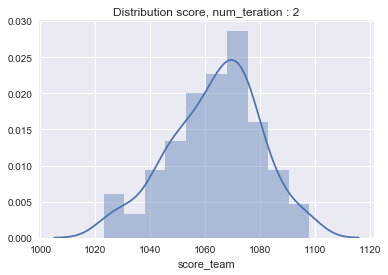

In [5]:
result_df = pd.read_excel('result_df_200_iteration.xlsx')

# Построим распределение стоимости и скора команл
result_df_mean_iteration = result_df.groupby('iter', as_index=False)\
                                    .aggregate({'cost_team' : np.mean, 'score_team' : np.mean})
plt.title('Distribution score, num_teration : {}'.format(num_iteration))
sns.distplot(result_df_mean_iteration['score_team'])
plt.show()

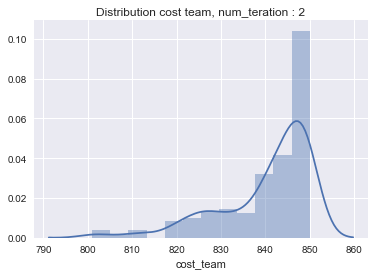

In [6]:
plt.title('Distribution cost team, num_teration : {}'.format(num_iteration))
sns.distplot(result_df_mean_iteration['cost_team'])
plt.show()

In [7]:
result_df_count_players = result_df.groupby(['player', 'position'], as_index=False)\
                                   .aggregate({'cost_team' : 'count'})\
                                   .rename(columns={'cost_team' : 'count'})\
                                   .sort_values('count', ascending=False)\
                                   .reset_index(drop=True)
result_df_count_players.head()
#def plotting_best_players_position(position, df, )

,player,position,count
0,Heung-MinSon,MID,195
1,JanBednarek,DEF,192
2,Bruno MiguelBorges Fernandes,MID,181
3,KurtZouma,DEF,145
4,HarryKane,FWD,142


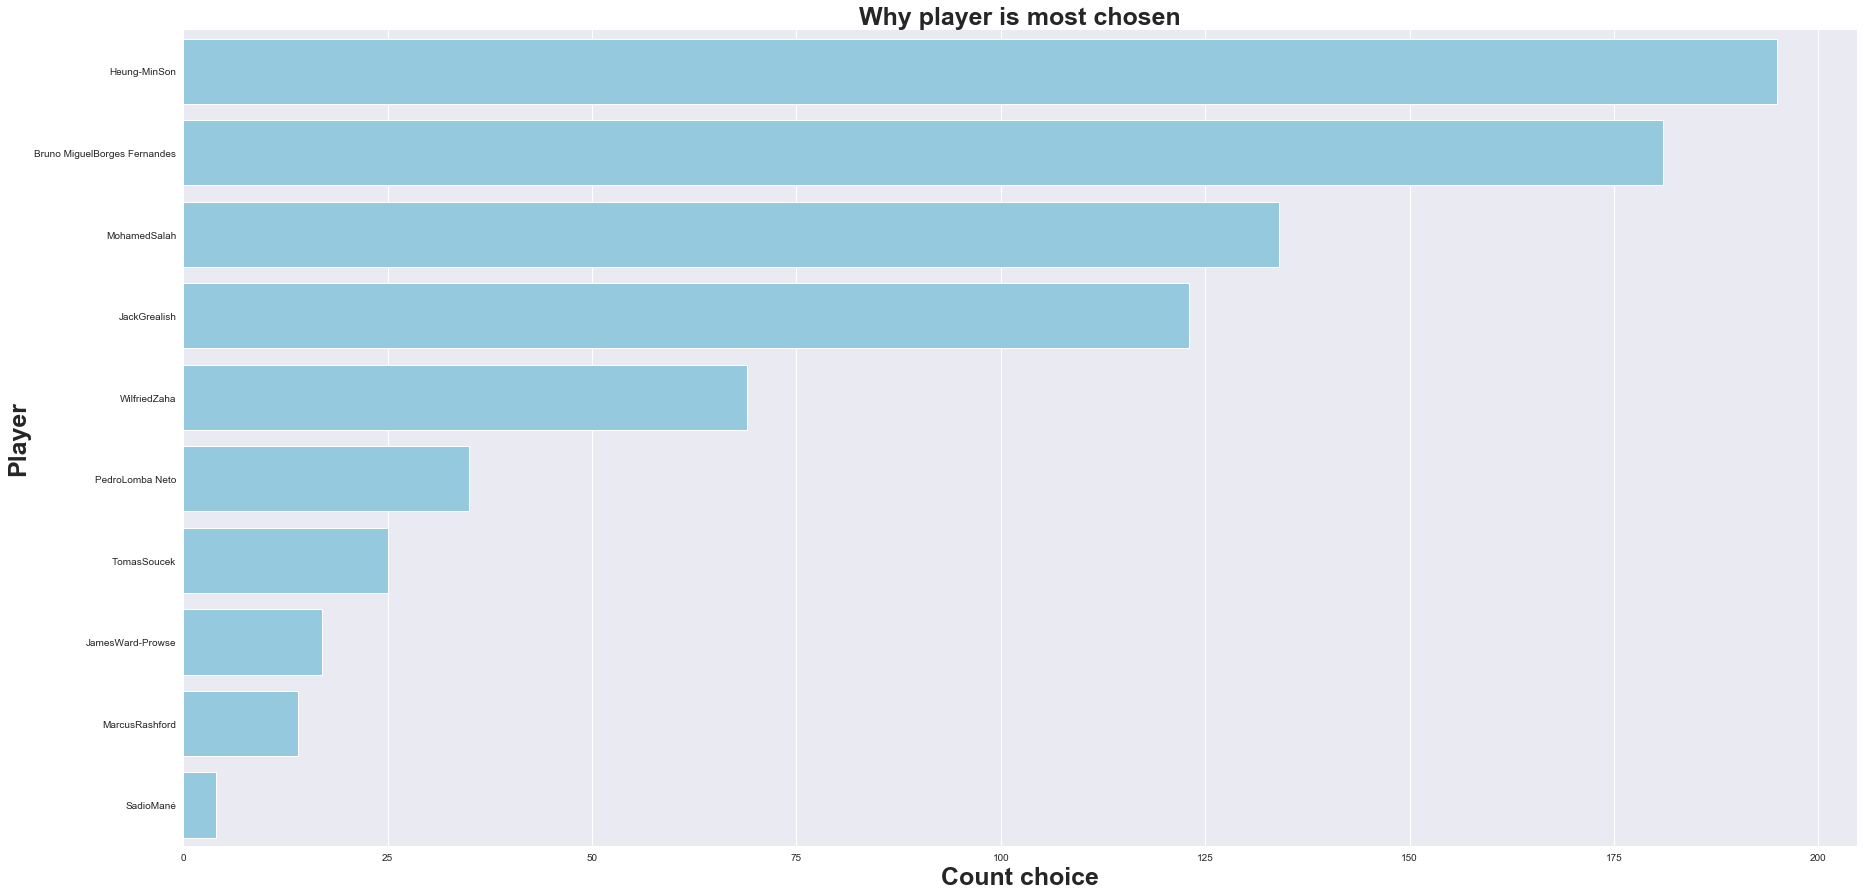

In [8]:
data_slice_def = result_df_count_players[result_df_count_players['position'] == 'MID']

fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.set(font_scale=5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
sns.barplot(x=data_slice_def['count'][:10], y=data_slice_def['player'][:10], 
            data=data_slice_def, color='skyblue')
plt.xlabel('Count choice', fontsize=25, weight = 'bold')
plt.ylabel('Player', fontsize=25, weight = 'bold')
plt.title('Why player is most chosen', fontsize=25, weight = 'bold')
plt.show()